### **Trabajo Final para la Cátedra de Fundamentos de Analítica I**
#### El objetivo del presente proyecto es validar la supervivencia en el Titanic, así como establecer una caracterización de los sobrevivientes y de aquellos que tuvieron el mismo final que Jack.

##### Realizado por:
  - Claudia Lorena Aragón 
  - Álvaro José Cabrera
  - Álvaro Rodríguez Lasso
  - Alfredo Aponte Segura

### 0. Instalación de librerías y paquetes

In [55]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import missingno as msno #previamente se debe instarlar a través de consola
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz #previamente se debe instarlar a través de consola

#Ignorar alertas 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew, kurtosis  ## funciones estadísticas
def tabla_descriptivas(columnas):
    tabla_descriptivas=pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation 0.30 | 0.30-0.70 | 0.70']=columnas.std()/columnas.mean()
    tabla_descriptivas.loc['skew < 0 sesgo izquierda | > 0 sesgo derecha ']=skew(columnas) #Sesgo o asimetría
    tabla_descriptivas.loc['kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica']=kurtosis(columnas)
    q1=columnas.quantile(0.25)
    q3=columnas.quantile(0.75)
    IQR=q3-q1
    outliers = columnas[ ((columnas<(q1-1.5*IQR)) | (columnas>(q3+1.5*IQR))) ]
    outlier_minimos = columnas[columnas<(q1-1.5*IQR)]
    outlier_maximos = columnas[columnas>(q3+1.5*IQR)]
    tabla_descriptivas.loc['Umbral atípicos minimo']=  columnas.quantile(0.25) - (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    tabla_descriptivas.loc['Umbral atípicos maximo']=  columnas.quantile(0.75) + (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    #tabla_descriptivas.loc['cantidad atipicos minimos']=   len(outlier_minimos)
    #tabla_descriptivas.loc['cantidad atipicos maximos']= len(outlier_maximos)
    #tabla_descriptivas.loc['cantidad_total_atípicos']= len(outliers)
    return tabla_descriptivas



### 1. Limpieza y EDA

#### Cargue de datos

In [56]:
df=pd.read_csv("train.csv") #Dataset de entrenamiento
df_2=pd.read_csv("test.csv") #Dataset de pruebasaa

In [57]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Validación general de formatos del dataset, datos faltantes y duplicados

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [59]:
df.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [60]:
df.duplicated().sum()

0

Encontramos un data set de entrenamiento con 891 registros. Las variables se encuentran correctamente formateadas.  Sin embargo, la variable "Cabin", presenta un 77% de datos faltantes por lo que se descartará del análisis posteriormente.  Por otro lado las variables "Age" y "Embarked" presentan aproxidamente un 20% de datos faltantes, por lo que se deberán imputar. FInalmente, no se presentan valores duplicados.

#### Eliminación de variables innecesarias del dataset

In [61]:
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df_2 = df_2.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

Eliminamos variables cualitativas que no nos aportan en nuestro objetivo o presentan mayor proporción de valores nulos: "PassengerId", "Name", "Ticker", "Cabin".

#### Análisis descriptivo

#### Distribución de las variables cuantitativas

In [71]:
tabla_descriptivas(df[['Age', 'SibSp','Parch','Fare']])

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200
coef. variation 0.30 | 0.30-0.70 | 0.70,0.489122,2.108464,2.112344,1.543073
skew < 0 sesgo izquierda | > 0 sesgo derecha,NaN,3.689128,2.744487,4.779253


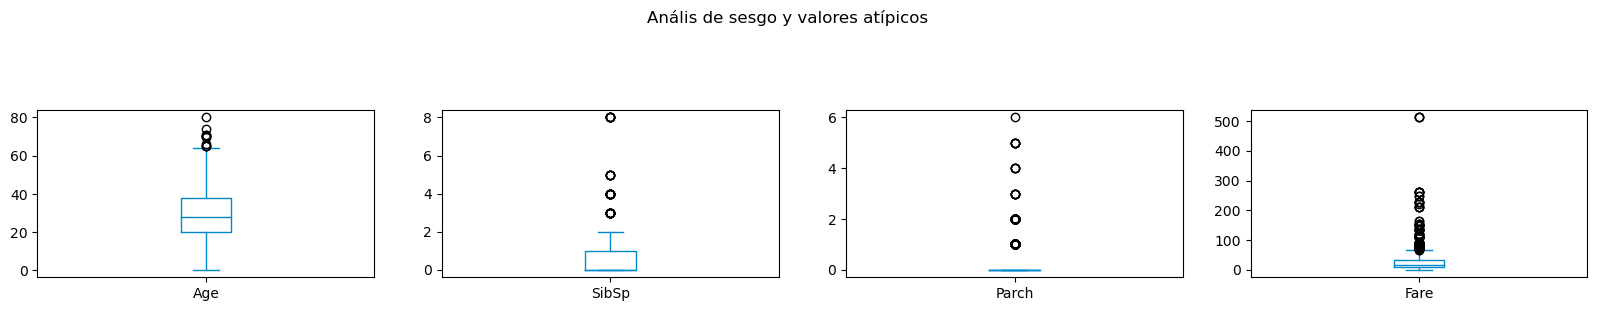

In [72]:
df_atipicos = df.drop(columns=['Pclass', 'Sex', 'Embarked', 'Survived'])
boxplot = df_atipicos.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,10), title='Anális de sesgo y valores atípicos', color="#008ACC" )
plt.show()

Age: 

-El 50% de la distribución de los datos se encuentra entre 20 y 38 años, con centro 28, es decir adultos jóvenes.

-Presenta unos cuantos atípicos de cara a edades máximas, superiores a 64 años. Son datos válidos.

Sibsp (nro. hermanos / cónyuges aboard the Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 1, con centro 0.

-Presenta unos cuantos atípicos máximos superiores a 2.

Parch (Nro. de padres / hijos a bordo del Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 0, con centro 0.

-Presenta unos cuantos atípicos máximo superiores a 0.

Fare (Tarifa)

-El 50% de la distribución de los datos se encuentra entre 7.91 y 31, con centro 14.4.

-Presenta una gran cantidad de datos atípicos, con valores superioes a 65.

#### Relación de variables cuantitativas Vs. variable objetivo

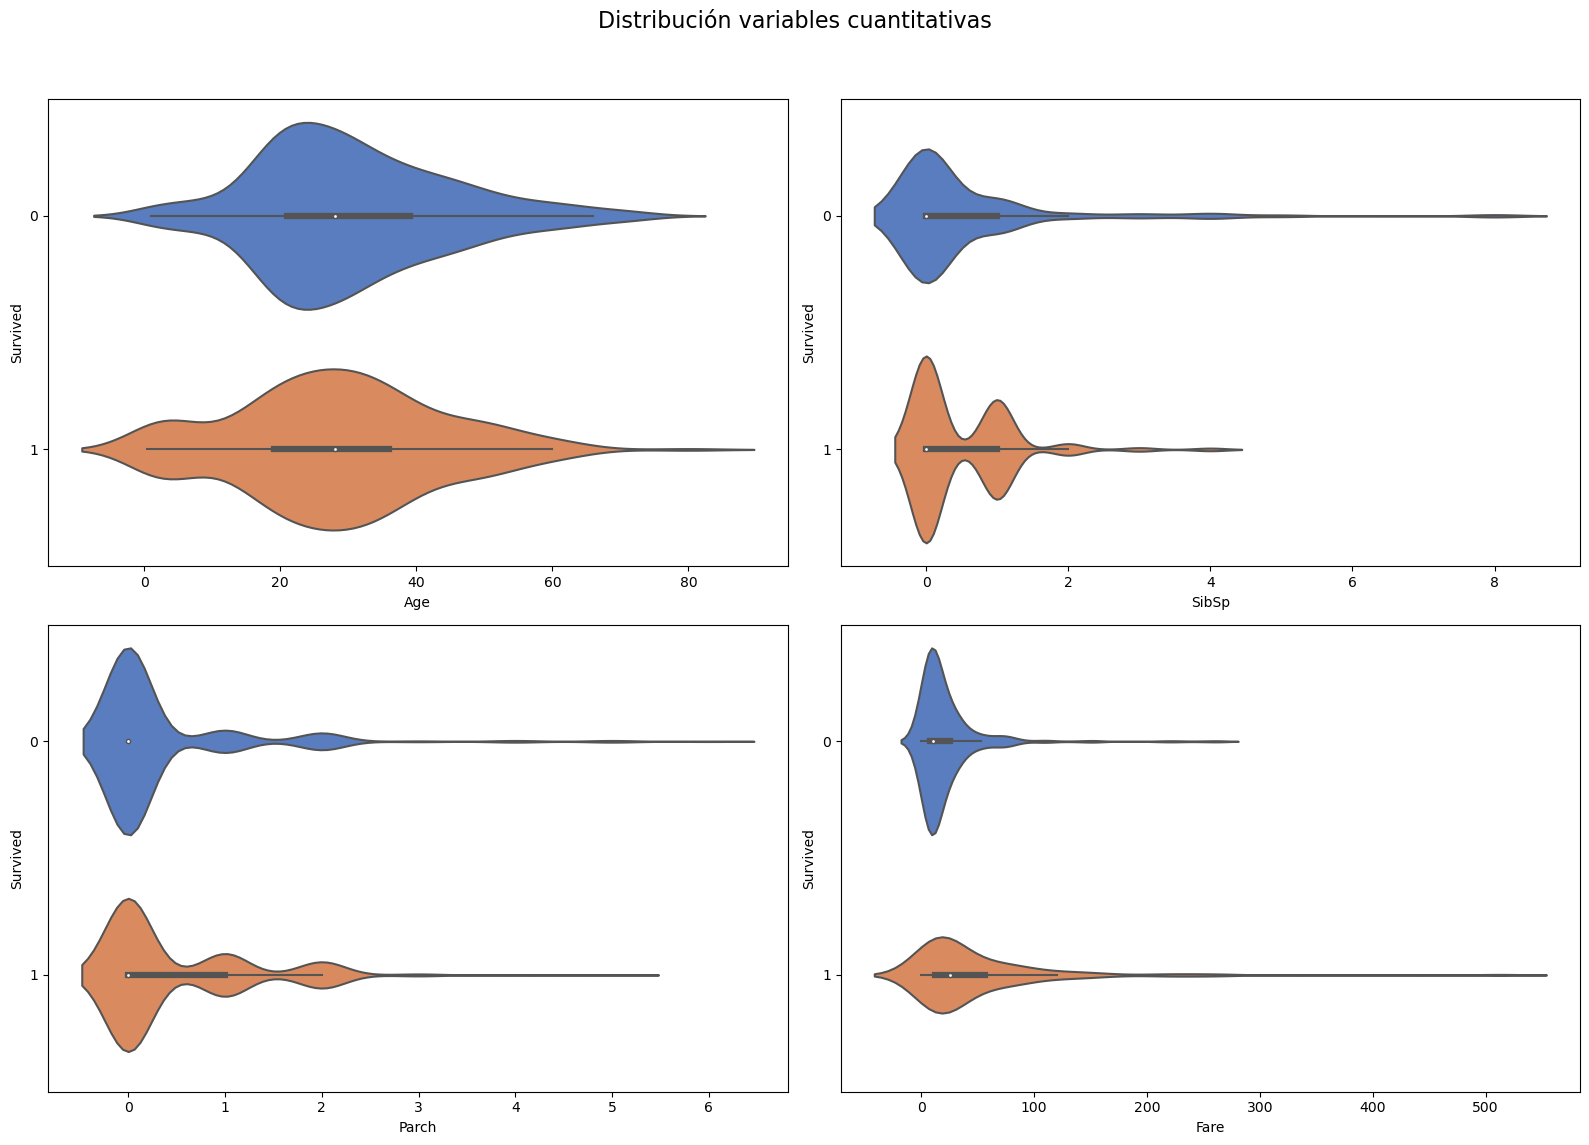

In [73]:
df['Survived'] = df['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización

# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Distribución variables cuantitativas', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2] # distribución del gráfico en la cuadrículas
    sns.violinplot(y='Survived', x=col, data=df, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # espacios de los subplots
plt.show()

#### Label encoding

In [25]:
#Label Encoding
mapping = {1: 'Upper', 2: 'Middle', 3: 'Lower'} # Reemplazar los valores en la columna 'Pclass'
df['Pclass'] = df['Pclass'].replace(mapping)
df_2['Pclass'] = df_2['Pclass'].replace(mapping)
df['Survived'] = df['Survived'].replace({1: 'Survived', 0: 'No'})
df_2['Survived'] = df['Survived'].replace({1: 'Survived', 0: 'No'})

#### Visualización de datos faltantes previo a imputación

Axes(0.125,0.11;0.698618x0.77)


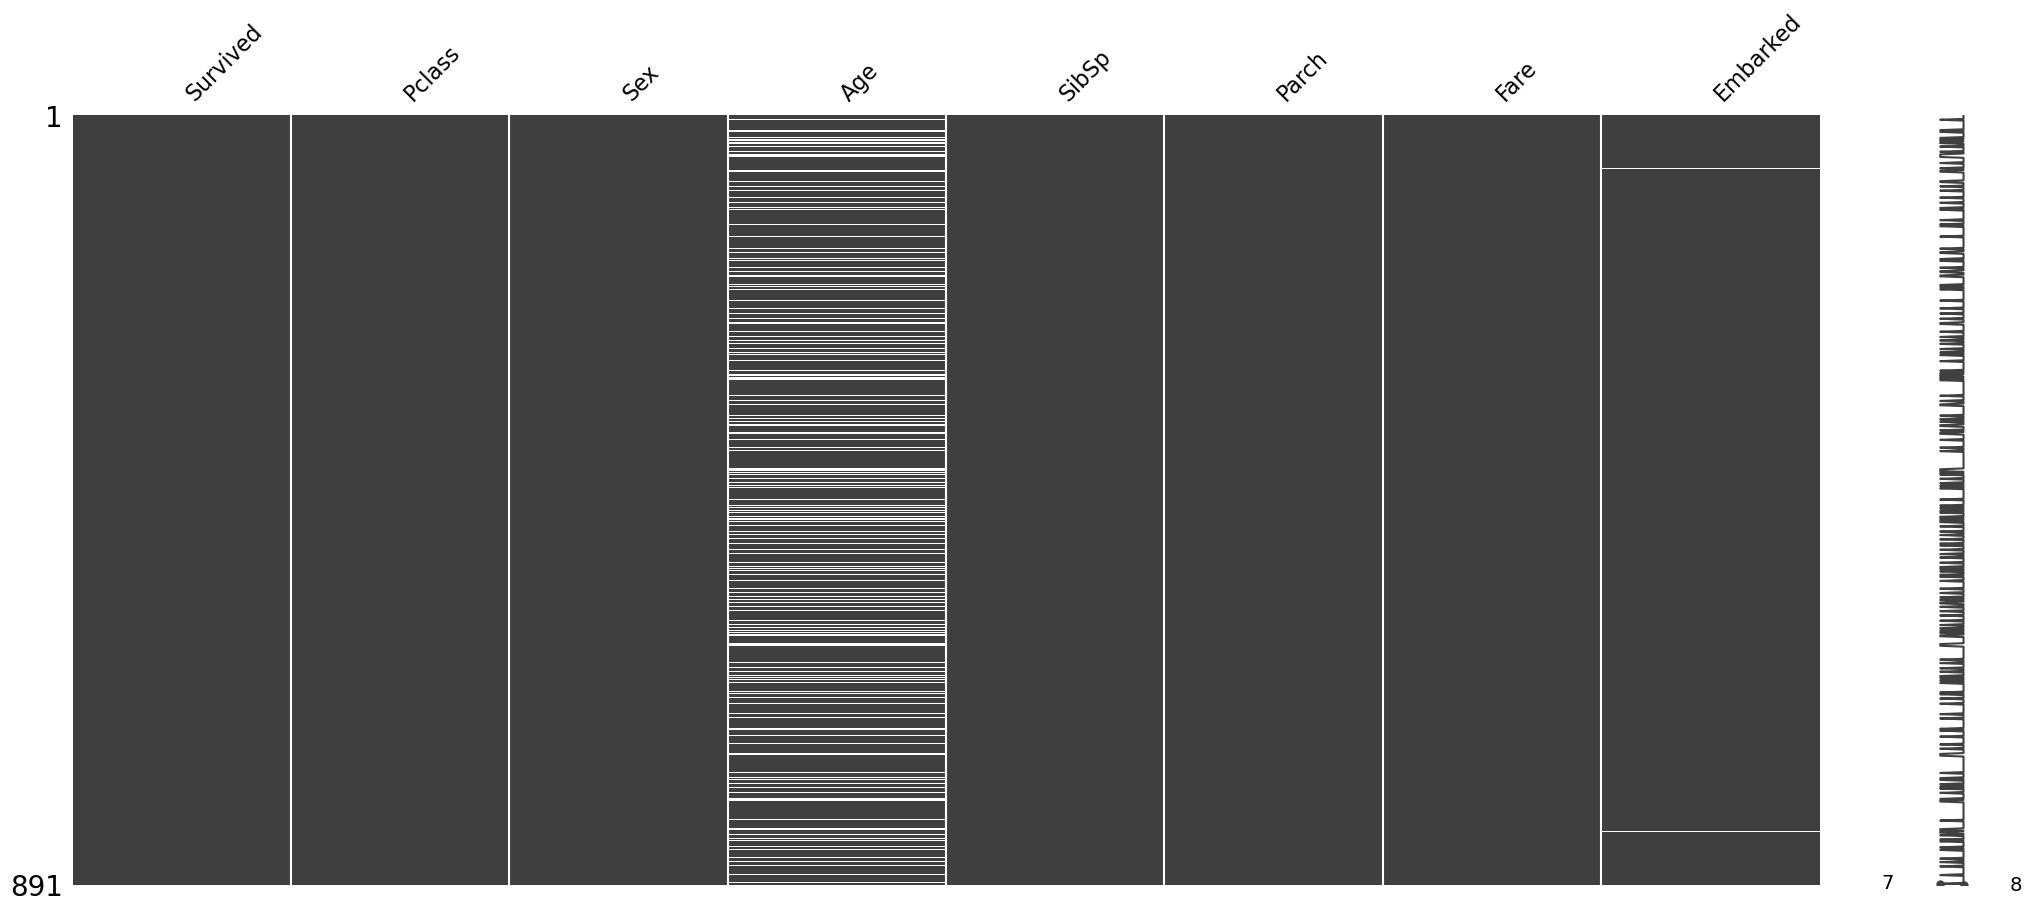

In [27]:
print(msno.matrix(df)) # Visualización de datos faltantes #

#### Imputación

Axes(0.125,0.11;0.698618x0.77)


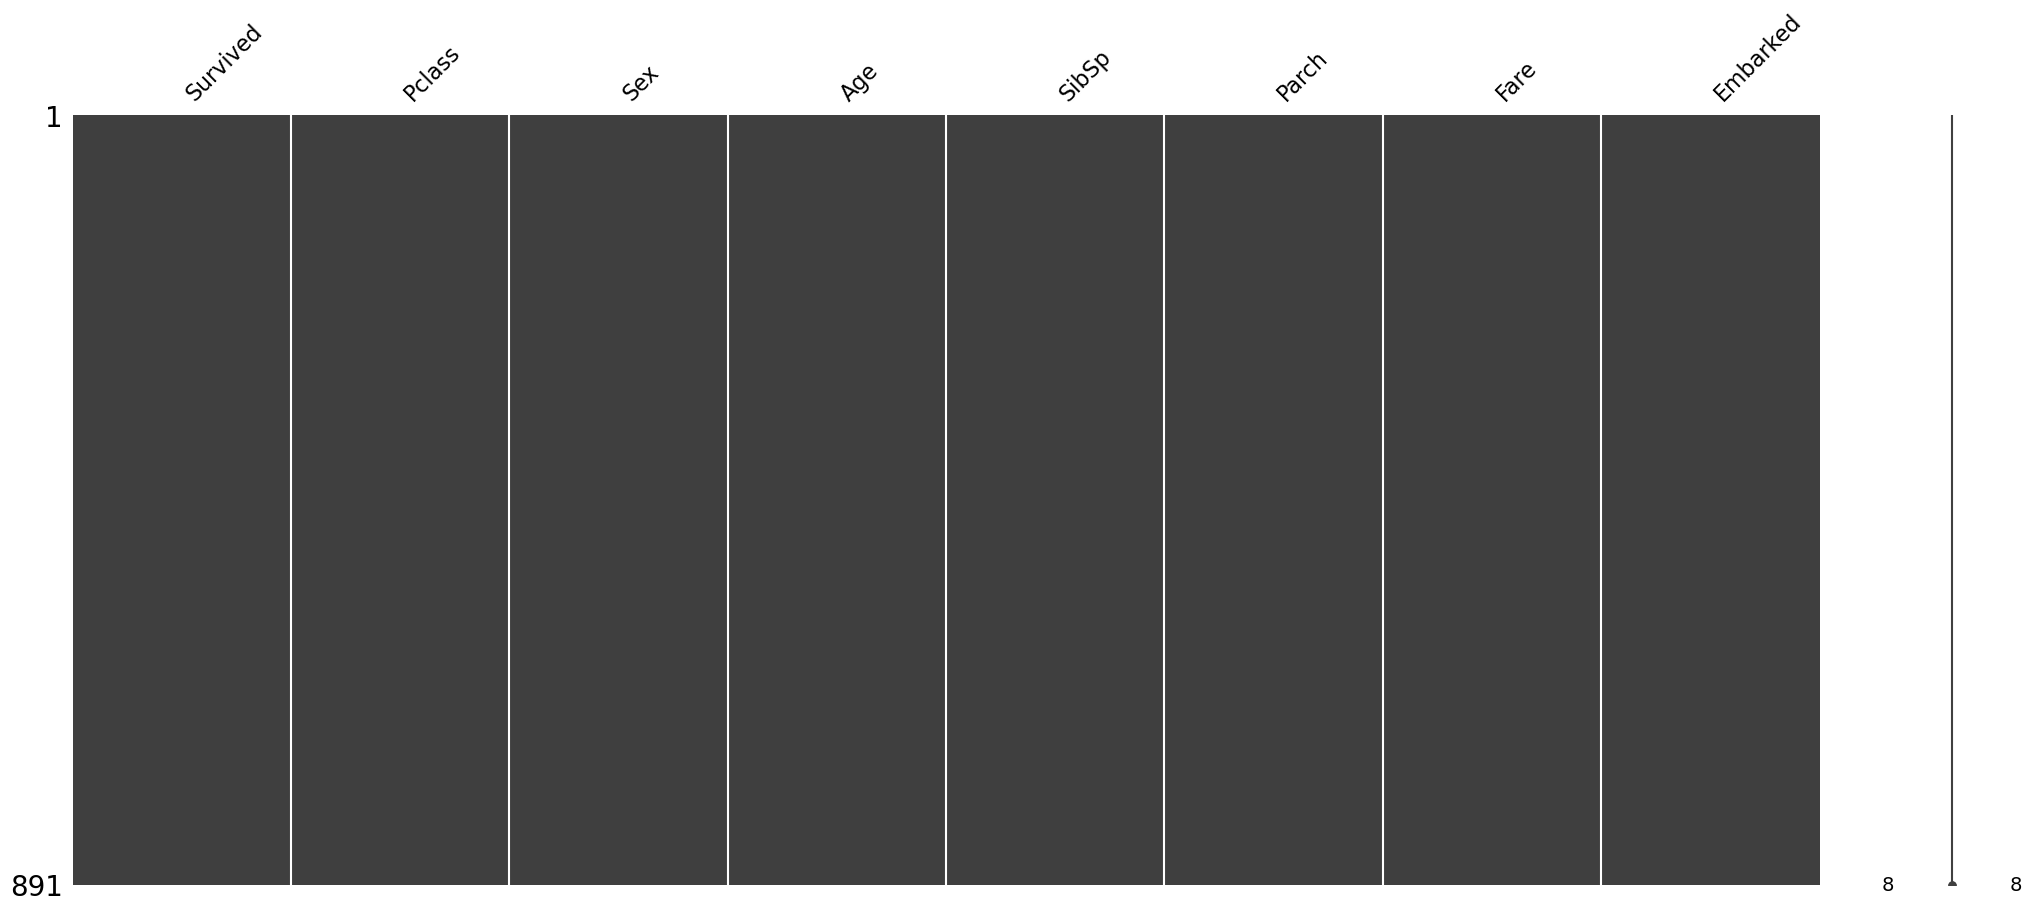

In [28]:
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df[['Embarked']]), columns=['Embarked'])
df['Embarked']=df_imputed['Embarked']

# Separa las variables cuantitativas de las cualitativas
# Las variables cuantitativas a imputar
quantitative_cols = ['Age', 'SibSp','Parch','Fare']

# Las variables cualitativas son 
qualitative_cols = ['Pclass', 'Sex', 'Embarked']

# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df[quantitative_cols] = knn_imputer.fit_transform(df[quantitative_cols])

# Segundo datasets
# Imputación #
df_imputed2 = pd.DataFrame(imputer.fit_transform(df_2[['Embarked']]), columns=['Embarked'])
df_2['Embarked']=df_imputed2['Embarked']

# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_2[quantitative_cols] = knn_imputer.fit_transform(df_2[quantitative_cols])

# Visualiza la matriz de valores faltantes después de la imputación
print(msno.matrix(df))

Se observa que los valores han sido correctamente imputados

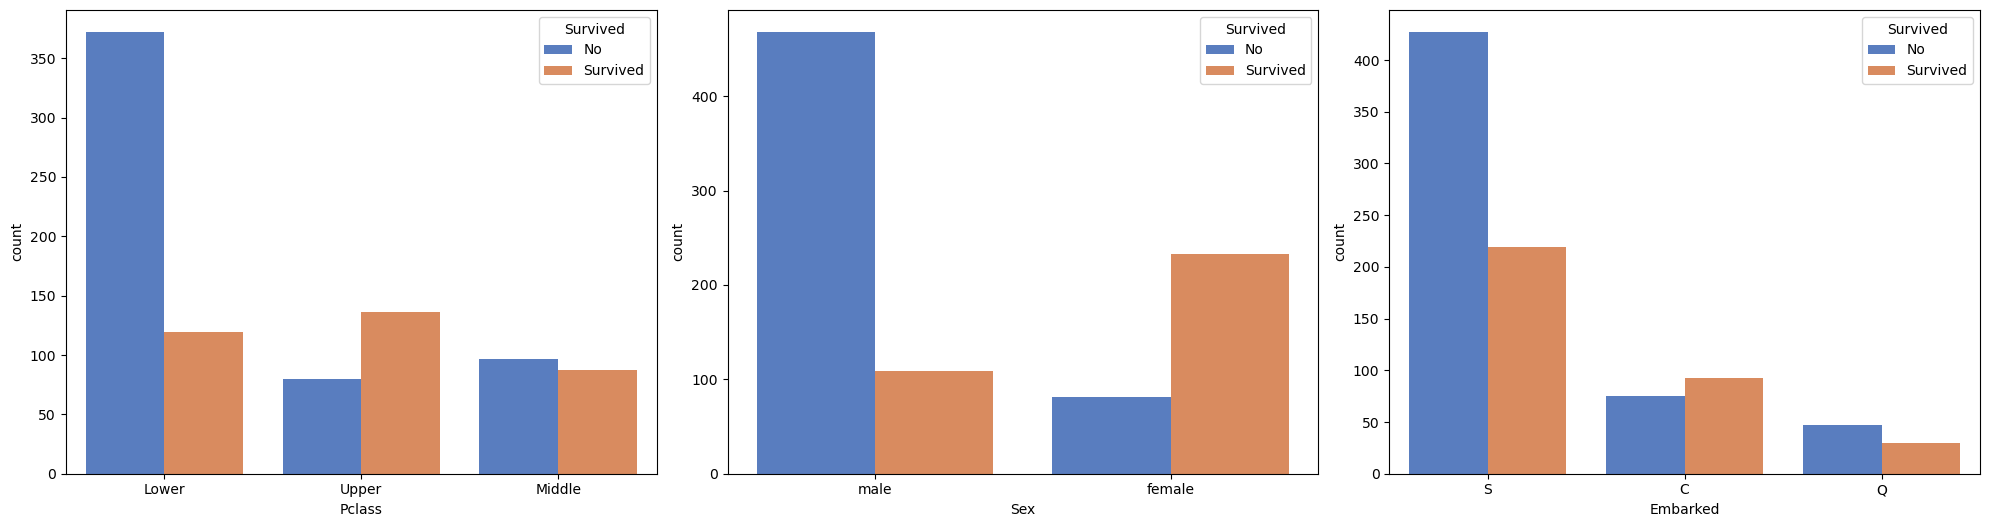

In [4]:
# Crear un tablero para gráficos de barras de variables cualitativas
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Survived', data=df, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


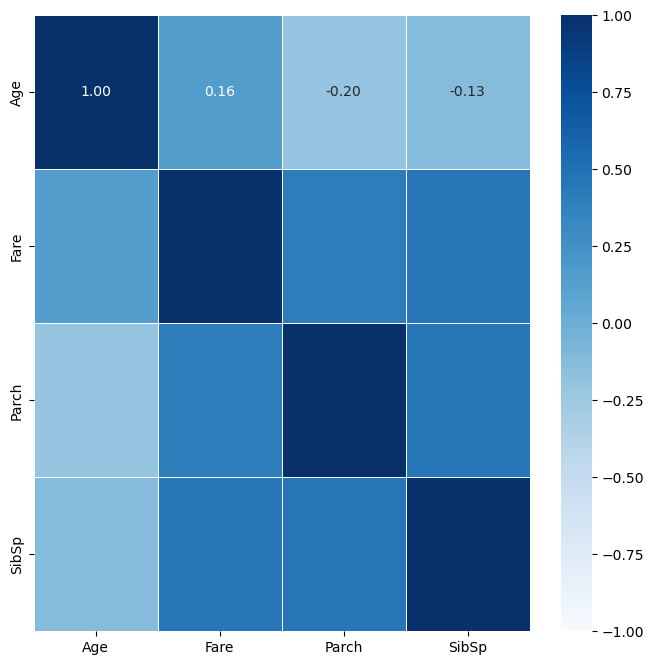

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [5]:
# Correlación

# Calcular la matriz de correlación de Spearman
corr_matrix = df[quantitative_cols].corr(method='spearman')

# Crear un heatmap de la matriz de correlación
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, cmap='Blues', vmin=-1, vmax=1, linewidths=0.5, linecolor='white', xticklabels= True, annot=True, fmt=".2f")
plt.show()
df.columns

In [6]:
X_train=df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X_test=df_2[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y_train=df.iloc[:,0]
y_test=df_2.iloc[:,7]



In [7]:
# Impute missing values in categorical columns
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
X_train[qualitative_cols] = imputer.fit_transform(X_train[qualitative_cols])
X_test[qualitative_cols] = imputer.transform(X_test[qualitative_cols])

# One-hot encode the categorical columns
X_train_encoded = pd.get_dummies(X_train[qualitative_cols], columns=qualitative_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test[qualitative_cols], columns=qualitative_cols, drop_first=True)

# Combine the encoded categorical columns with the numerical columns
X_train_final = pd.concat([X_train_encoded, X_train.drop(columns=qualitative_cols)], axis=1)
X_test_final = pd.concat([X_test_encoded, X_test.drop(columns=qualitative_cols)], axis=1)
y_train=df['Survived']
y_test=df_2['Survived']

### 2. Modelos predictivos: 

#### 2.1 Modelo de regresion Lineal 

In [8]:
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_final, y_train)

y_pred = logreg.predict(X_test_final)

In [9]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[156,  99],
       [110,  53]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

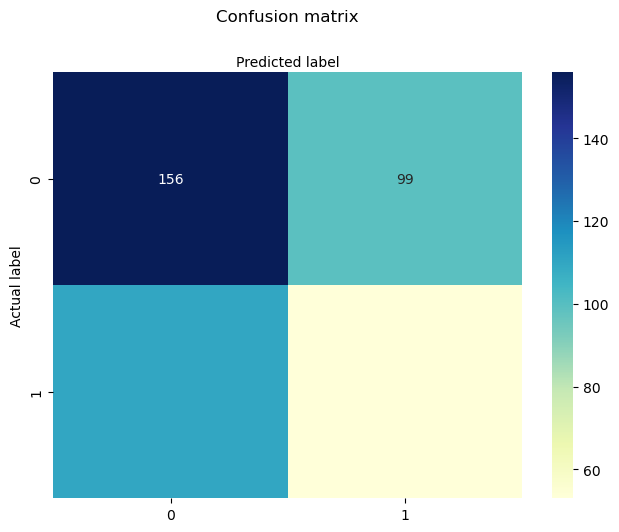

In [10]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [11]:
from sklearn.metrics import classification_report
target_names = ['No', 'Survived']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

          No       0.59      0.61      0.60       255
    Survived       0.35      0.33      0.34       163

    accuracy                           0.50       418
   macro avg       0.47      0.47      0.47       418
weighted avg       0.49      0.50      0.50       418



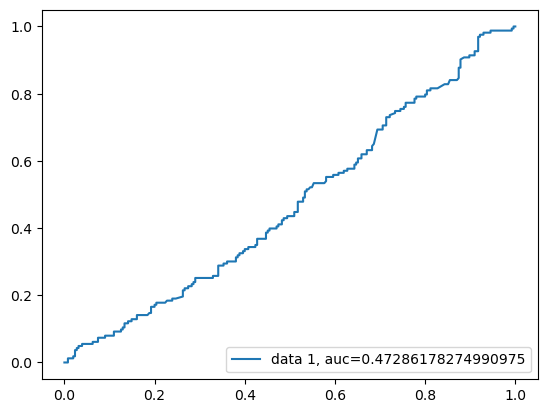

In [12]:
y_test_binary = y_test.map({'No': 0, 'Survived': 1})
y_pred_proba = logreg.predict_proba(X_test_final)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test_binary, y_pred_proba)
auc = metrics.roc_auc_score(y_test_binary, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### 2.2 Modelo Random Forest

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train_final, y_train)
y_pred = rf.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print(classification_report(y_test, y_pred, target_names=target_names))

[[159  96]
 [107  56]]
              precision    recall  f1-score   support

          No       0.60      0.62      0.61       255
    Survived       0.37      0.34      0.36       163

    accuracy                           0.51       418
   macro avg       0.48      0.48      0.48       418
weighted avg       0.51      0.51      0.51       418



In [14]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002111AD2E550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002111ACEFBD0>})

In [15]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 99}


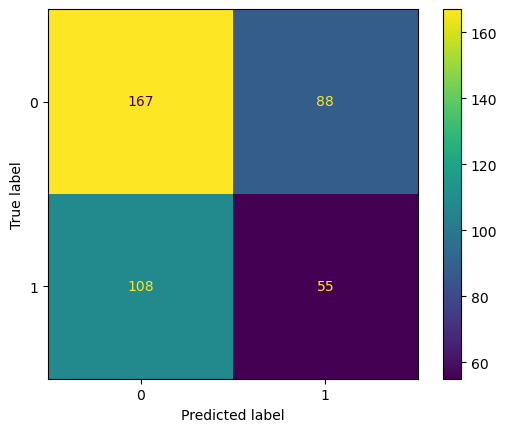

In [16]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test_final)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

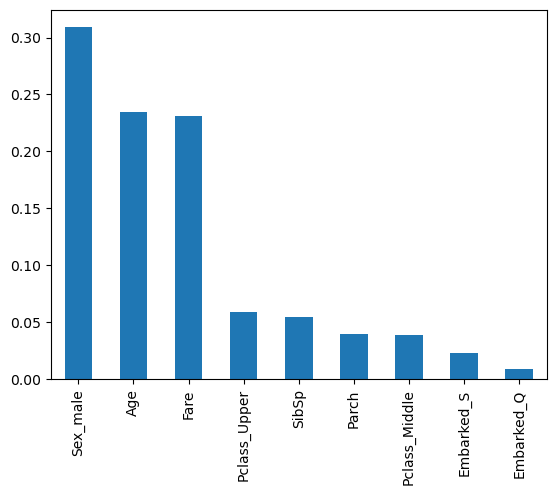

In [17]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_test_final.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

#### 2.3 Modelo Decision Tree

In [18]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [19]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_final,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)


In [20]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.507177033492823


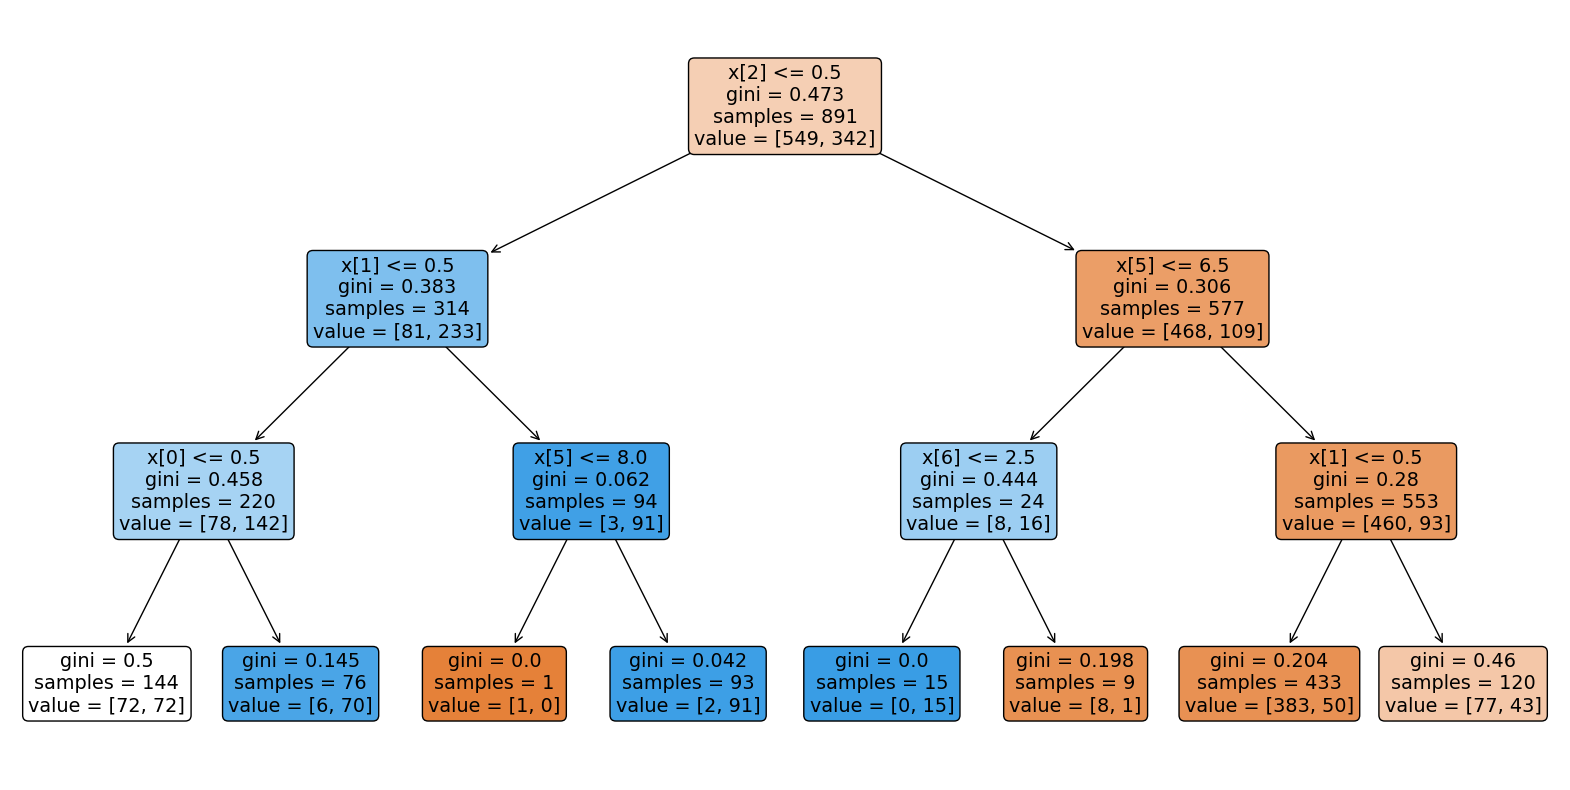

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Create Decision Tree classifer object with max_depth=3
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_final, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, rounded=True)
plt.show()

In [22]:
X_train_final

,Pclass_Middle,Pclass_Upper,Sex_male,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare
0,False,False,True,False,True,22.0,1,0,7.2500
1,False,True,False,False,False,38.0,1,0,71.2833
2,False,False,False,False,True,26.0,0,0,7.9250
3,False,True,False,False,True,35.0,1,0,53.1000
4,False,False,True,False,True,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...
886,True,False,True,False,True,27.0,0,0,13.0000
887,False,True,False,False,True,19.0,0,0,30.0000
888,False,False,False,False,True,28.0,1,2,23.4500
889,False,True,True,False,False,26.0,0,0,30.0000


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.81      0.93      0.86       549
    Survived       0.85      0.65      0.74       342

    accuracy                           0.82       891
   macro avg       0.83      0.79      0.80       891
weighted avg       0.82      0.82      0.81       891

Exactitud:
0.8204264870931538


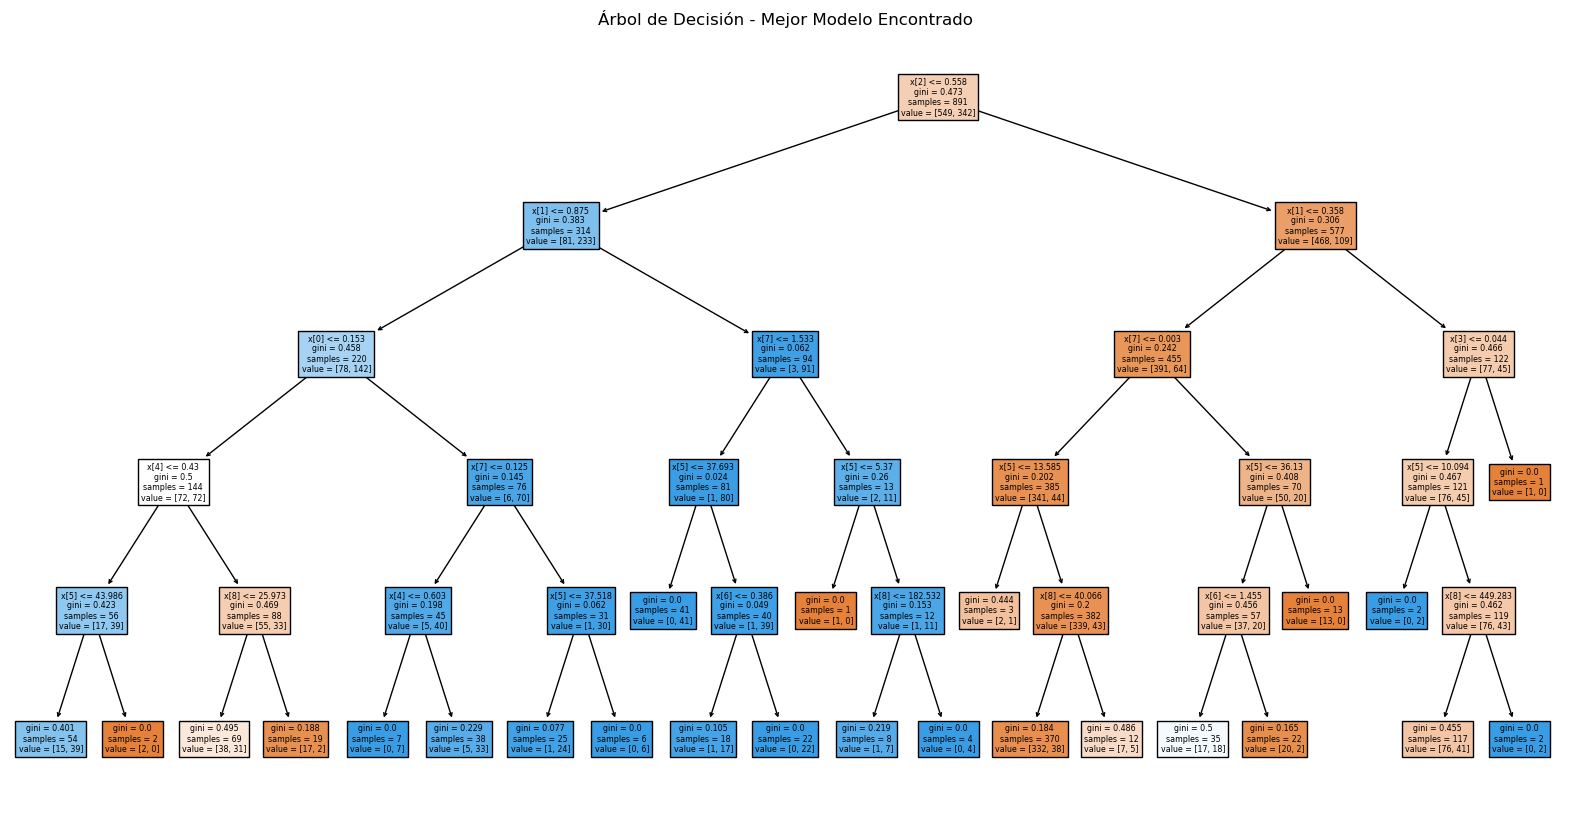

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
# Paso 3: Definir el modelo
dt = DecisionTreeClassifier()

# Paso 4: Definir los hiperparámetros a probar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5,10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Paso 5: Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_final, y_train)

# Paso 6: Obtener los mejores parámetros y evaluar el modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train_final)

print("Reporte de clasificación:")
print(classification_report(y_train, y_pred))

print("Exactitud:")
print(accuracy_score(y_train, y_pred))
# Paso 7: Graficar el mejor árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_model,filled=True)
plt.title("Árbol de Decisión - Mejor Modelo Encontrado")
plt.show()

#### 3. Reducción de dimensionalidad

#### 4. Caracterización de los pasajeros: